Text(0, 0.5, 'Amplitude')

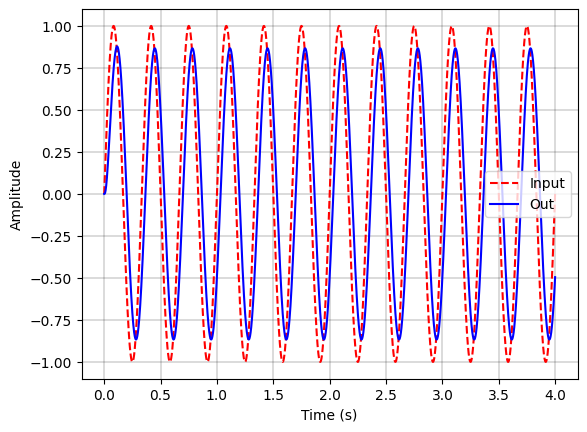

In [520]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt

# Define the system transfer function
R1 = 10e3
C1 = 1e-6
R2 = 15e3
C2 = 1e-6
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]

sys_continuos = cnt.tf(num, den)

# Define the simulation time and input signal
freq = 3 #Hz
t = np.linspace(0, 4, 5000)
u = np.sin(2*np.pi*t*3)

t_ol, y_ol = cnt.forced_response(sys_continuos, t, u)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


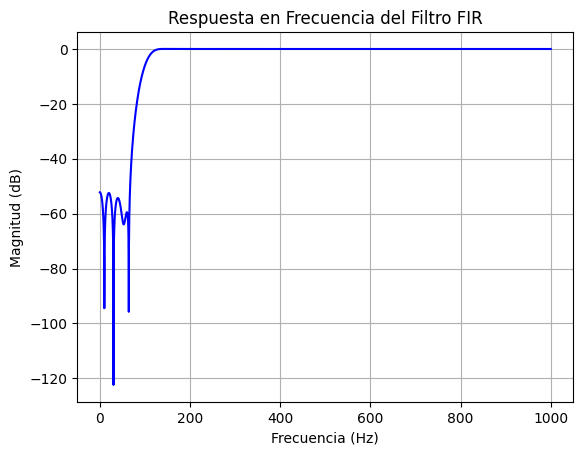

In [521]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt
import FIR_coeficients as coefs
from scipy.signal import freqz, chirp

'''
    Hay que tener en cuenta que para un filtro FIR la ecuacion en diferencias
    tiene denominador 1.
'''

filter_order = 101           # Orden del filtro
cutoff_freq = [100]         # Frecuencias de corte para el filtro pasabanda
fs = 2000                  # Frecuencia de muestreo en Hz
filter_type = 'highpass'     # Tipo de filtro
window = 'hamming'          # Tipo de ventana

num_filter_discrete = coefs.design_fir_filter(filter_order, cutoff_freq, fs, filter_type, window)['coefs']
den_filter_discrete = [1]

fil_tf = cnt.tf(num_filter_discrete, den_filter_discrete)
fil_sys = cnt.feedback(fil_tf, 1)

# Calcular la respuesta en frecuencia del filtro
w, h = freqz(num_filter_discrete, worN=8000, fs=fs)

# Graficar la respuesta en frecuencia
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h)), 'b')
plt.title('Respuesta en Frecuencia del Filtro FIR')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid()

In [522]:
R1 = 10e3
C1 = 1e-6
R2 = 15e3
C2 = 1e-6
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys_continuos = cnt.tf(num, den)

h = 1/fs
sys_discrete = cnt.c2d(sys_continuos, h, 'zoh')
num_sys_discrete, den_sys_discrete = cnt.tfdata(sys_discrete)

num_sys_discrete = num_sys_discrete[0][0]
den_sys_discrete = den_sys_discrete[0][0]

print("COEFICIENTES DEL SISTEMA CONTINUO DISCRETIZADO")
print(num_sys_discrete,den_sys_discrete)



COEFICIENTES DEL SISTEMA CONTINUO DISCRETIZADO
[0.00080174 0.00077116] [ 1.         -1.88830887  0.88988177]


In [523]:
# Test sobre los coeficientes del filtro generado
input_buffer_SYS = [0] * len(num_sys_discrete)
output_buffer_SYS = [0] * (len(den_sys_discrete) - 1)

input_buffer_FILTER = [0] * len(num_filter_discrete)
output_buffer_FILTER = [0] * (len(den_filter_discrete) - 1)

def f_recurrence_SYS(num, den, input_value):
    global input_buffer_SYS, output_buffer_SYS

    # Desplazar valores en el buffer de entrada
    for i in range(len(num) - 1, 0, -1):
        input_buffer_SYS[i] = input_buffer_SYS[i - 1]
    input_buffer_SYS[0] = input_value
    
    output = 0
    
    # Calcular numerador
    for m in range(len(num)):
        output += num[m] * input_buffer_SYS[m]
        # print("num out {} : {}".format(m,output))
    
    # Calcular denominador
    for n in range(1, len(den)):
        output -= den[n] * output_buffer_SYS[n - 1]
        # print("den out {} : {}".format(n,output))
      
    for i in range(len(den) - 2, 0, -1):
        output_buffer_SYS[i] = output_buffer_SYS[i - 1]
    output_buffer_SYS[0] = output
    
    return output

def f_recurrence_FILTER(num, den, input_value):
    global input_buffer_FILTER, output_buffer_FILTER

    # Desplazar valores en el buffer de entrada
    for i in range(len(num) - 1, 0, -1):
        input_buffer_FILTER[i] = input_buffer_FILTER[i - 1]
    input_buffer_FILTER[0] = input_value
    
    output = 0
    
    # Calcular numerador
    for m in range(len(num)):
        output += num[m] * input_buffer_FILTER[m]
        # print("num out {} : {}".format(m,output))
    
    '''
        COMENTO LA PARTE DEL DENOMINADOR PARA EL FILTRO FIR
        PARA UN FILTRO IIR HAY QUE AGREGARLO
    '''
    # Calcular denominador
    # for n in range(1, len(den)):
    #     output -= den[n] * output_buffer_FILTER[n - 1]
    #     print("den out {} : {}".format(n,output))
      
    # for i in range(len(den) - 2, 0, -1):
    #     output_buffer_FILTER[i] = output_buffer_FILTER[i - 1]
    # output_buffer_FILTER[0] = output
    
    return output

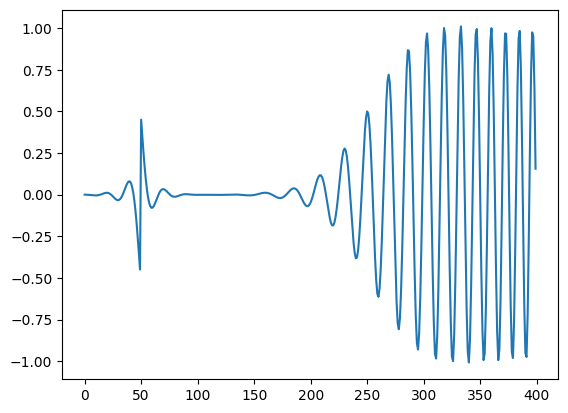

In [524]:

freq = 120

T = 0.1 # segundos

t = np.arange(0, T, h)
u120 = np.sin(np.pi*2*t*freq)

sys_alone = []
for i in u:
    sys_alone.append(f_recurrence_SYS(num_sys_discrete, den_sys_discrete, i))

# Test to try 120 hz, after a certain time should get to the value of 1
filter_120hz_highpass = []
for i in u120:
    filter_120hz_highpass.append(f_recurrence_FILTER(num_filter_discrete, den_filter_discrete, i))

# Set a new 
freq = 60
u60 = np.sin(np.pi*2*t*freq)

# Reset buffers
input_buffer_FILTER = [0] * len(num_filter_discrete)
output_buffer_FILTER = [0] * (len(den_filter_discrete) - 1)

# Test to try 60 hz, should be always below 1
filter_60hz_highpass = []
for i in u60:
    filter_60hz_highpass.append(f_recurrence_FILTER(num_filter_discrete, den_filter_discrete, i))


# New values for the chirp signal
T = 0.2
f0 = 0
f1 = 200
t = np.linspace(0, T, int(fs * T), endpoint=False)
chirp_signal = chirp(t, f0=f0, f1=f1, t1=T, method='linear')


# Reset buffers
input_buffer_FILTER = [0] * len(num_filter_discrete)
output_buffer_FILTER = [0] * (len(den_filter_discrete) - 1)

# Test to try 60 hz, should be always below 1
filter_chirp = []
for i in chirp_signal:
    filter_chirp.append(f_recurrence_FILTER(num_filter_discrete, den_filter_discrete, i))


# plt.plot(filter_120hz_highpass)
# plt.plot(filter_60hz_highpass)
plt.plot(filter_chirp)
# plt.plot(sys_alone)
# plt.plot(u120)
# plt.plot(u60)